# Projet IA
## Préparation des données

### Initialisation du projet

In [42]:
# imports
import numpy as np
import seaborn as sns
import os

from numpy.random import default_rng
# stabilité du notebook d'une exécution à l'autre
random=default_rng(420) 

# jolies figures directement dans le notebook
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# où sauver les figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "projet"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "img") # le dossier doit exister

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=500):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

### Importation

In [43]:
import os
import pandas as pd

dataSets_Path = os.path.join(".\datasets")

generalData = pd.read_csv(os.path.join(dataSets_Path, "general_data.csv"))
employeeData = pd.read_csv(os.path.join(dataSets_Path, "employee_survey_data.csv"))
managerData = pd.read_csv(os.path.join(dataSets_Path, "manager_survey_data.csv"))
csvInTimeData = pd.read_csv(os.path.join(dataSets_Path, "in_time.csv"))
csvOutTimeData = pd.read_csv(os.path.join(dataSets_Path, "out_time.csv"))

intTimeData = csvInTimeData.rename(columns={'Unnamed: 0': 'EmployeeID'})
outTimeData = csvOutTimeData.rename(columns={'Unnamed: 0': 'EmployeeID'})

In [44]:
allData = pd.merge(employeeData, generalData, how='inner', on=['EmployeeID'])
allData = allData.merge(managerData, how='inner', on=['EmployeeID'])

""" allData = allData.merge(intTimeData, how='inner', on=['EmployeeID'])
allData = allData.merge(outTimeData, how='inner', on=['EmployeeID']) """

Test = allData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4410 entries, 0 to 4409
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   EmployeeID               4410 non-null   int64  
 1   EnvironmentSatisfaction  4385 non-null   float64
 2   JobSatisfaction          4390 non-null   float64
 3   WorkLifeBalance          4372 non-null   float64
 4   Age                      4410 non-null   int64  
 5   Attrition                4410 non-null   object 
 6   BusinessTravel           4410 non-null   object 
 7   Department               4410 non-null   object 
 8   DistanceFromHome         4410 non-null   int64  
 9   Education                4410 non-null   int64  
 10  EducationField           4410 non-null   object 
 11  EmployeeCount            4410 non-null   int64  
 12  Gender                   4410 non-null   object 
 13  JobLevel                 4410 non-null   int64  
 14  JobRole                 

### Decode valeur

In [45]:
allData['PerformanceRating'] = allData['PerformanceRating'].replace({ 1 : 'Low', 2: 'Good',3: 'Excellent',4: 'Outstanding'})
allData['EnvironmentSatisfaction'] = allData['EnvironmentSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
allData['JobSatisfaction'] = allData['JobSatisfaction'].replace({ 1 : 'Low', 2: 'Medium',3: 'High',4: 'Very High'})
allData['WorkLifeBalance'] = allData['WorkLifeBalance'].replace({ 1 : 'Bad', 2: 'Good',3: 'Better',4: 'Best'})


In [46]:
allData.describe(include="all")

,EmployeeID,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,...,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating
count,4410.000000,4385,4390,4372,4410.000000,4410,4410,4410,4410.000000,4410.000000,...,4410.000000,4410.0,4410.000000,4401.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410
unique,NaN,4,4,4,NaN,2,3,3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
top,NaN,High,Very High,Better,NaN,No,Travel_Rarely,Research & Development,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Excellent
freq,NaN,1350,1367,2660,NaN,3699,3129,2883,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3732
mean,2205.500000,NaN,NaN,NaN,36.923810,NaN,NaN,NaN,9.192517,2.912925,...,15.209524,8.0,0.793878,11.279936,2.799320,7.008163,2.187755,4.123129,2.729932,NaN
std,1273.201673,NaN,NaN,NaN,9.133301,NaN,NaN,NaN,8.105026,1.023933,...,3.659108,0.0,0.851883,7.782222,1.288978,6.125135,3.221699,3.567327,0.711400,NaN
min,1.000000,NaN,NaN,NaN,18.000000,NaN,NaN,NaN,1.000000,1.000000,...,11.000000,8.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,NaN
25%,1103.250000,NaN,NaN,NaN,30.000000,NaN,NaN,NaN,2.000000,2.000000,...,12.000000,8.0,0.000000,6.000000,2.000000,3.000000,0.000000,2.000000,2.000000,NaN
50%,2205.500000,NaN,NaN,NaN,36.000000,NaN,NaN,NaN,7.000000,3.000000,...,14.000000,8.0,1.000000,10.000000,3.000000,5.000000,1.000000,3.000000,3.000000,NaN
75%,3307.750000,NaN,NaN,NaN,43.000000,NaN,NaN,NaN,14.000000,4.000000,...,18.000000,8.0,1.000000,15.000000,3.000000,9.000000,3.000000,7.000000,3.000000,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D42FCF1848>,
      dtype=object)

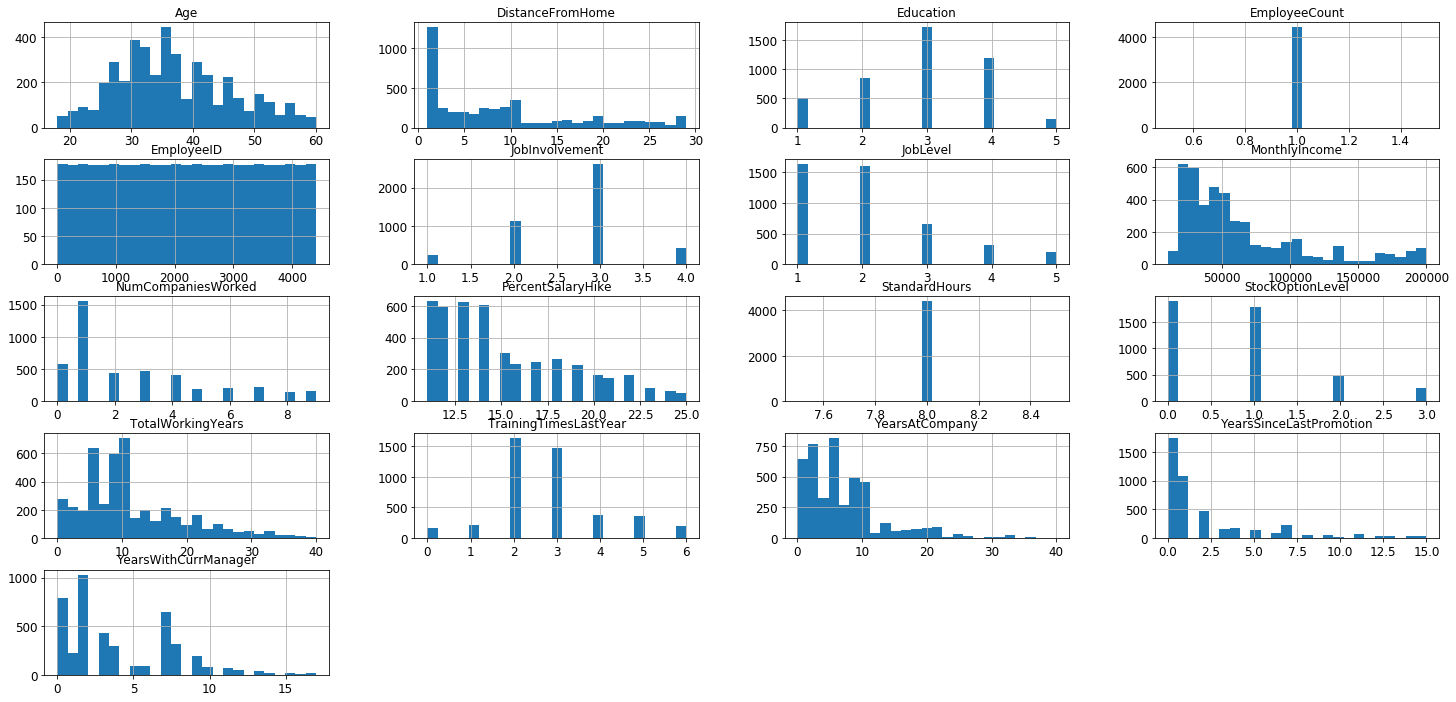

In [47]:
allData.hist(figsize=(25,12), bins=25,column=list(allData.columns))

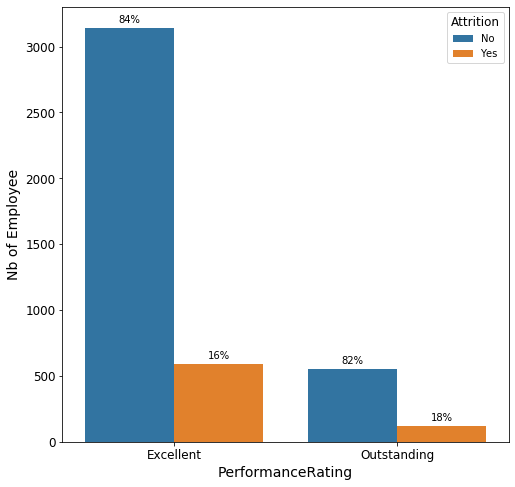

In [48]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='PerformanceRating', data=allData, hue="Attrition")
ax.set_ylabel('Nb of Employee')
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

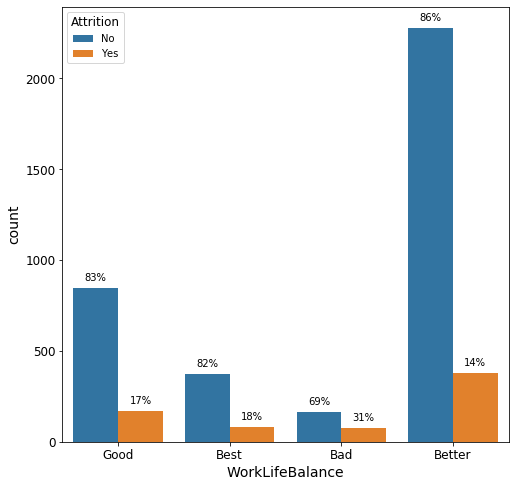

In [41]:
plt.figure(figsize=(8,8))
ax = sns.countplot(x='WorkLifeBalance', data=allData, hue="Attrition")
bars = ax.patches
half = int(len(bars)/2)
left_bars = bars[:half]
right_bars = bars[half:]

for left, right in zip(left_bars, right_bars):
    height_l = left.get_height()
    height_r = right.get_height()
    total = height_l + height_r

    ax.text(left.get_x() + left.get_width()/2., height_l + 40, '{0:.0%}'.format(height_l/total), ha="center")
    ax.text(right.get_x() + right.get_width()/2., height_r + 40, '{0:.0%}'.format(height_r/total), ha="center")

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage

X = allData.copy() # A new copy of data set
X.drop("Attrition", axis=1, inplace=True) # Not numerical
X.drop("BusinessTravel", axis=1, inplace=True) # Not numerical
X.drop("EducationField", axis=1, inplace=True) # Not numerical
X.drop("Department", axis=1, inplace=True) # Not numerical
X.drop("Gender", axis=1, inplace=True) # Not numerical
X.drop("JobRole", axis=1, inplace=True) # Not numerical
X.drop("MaritalStatus", axis=1, inplace=True) # Not numerical
X.drop("Over18", axis=1, inplace=True) # Not numerical
X.drop("EnvironmentSatisfaction", axis=1, inplace=True) # Missing values
X.drop("JobSatisfaction", axis=1, inplace=True) # Missing values
X.drop("WorkLifeBalance", axis=1, inplace=True) # Missing values
X.drop("NumCompaniesWorked", axis=1, inplace=True) # Missing values
X.drop("TotalWorkingYears", axis=1, inplace=True) # Missing values

X.head()

,EmployeeID,Age,DistanceFromHome,Education,EmployeeCount,JobLevel,MonthlyIncome,PercentSalaryHike,StandardHours,StockOptionLevel,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,JobInvolvement,PerformanceRating
0,1,51,6,2,1,1,131160,11,8,0,6,1,0,0,3,3
1,2,31,10,1,1,1,41890,23,8,1,3,5,1,4,2,4
2,3,32,17,4,1,4,193280,15,8,3,2,5,0,3,3,3
3,4,38,2,5,1,3,83210,11,8,3,5,8,7,5,2,3
4,5,32,10,1,1,1,23420,12,8,2,2,6,0,4,3,3


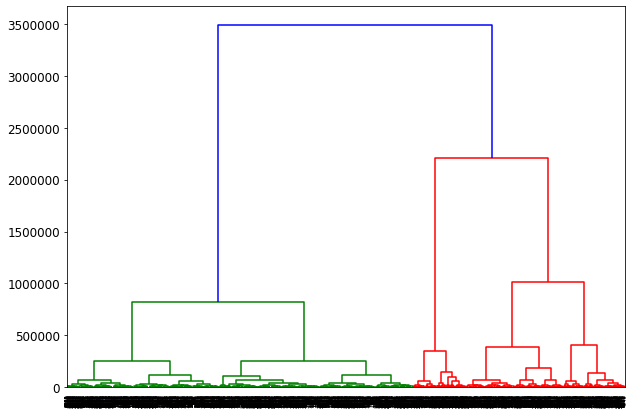

In [7]:
plt.figure(figsize=(10, 7))
dendrogram(linkage(X, method='ward'), orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.show()

#### Echantillonage stratifié

On considère que la distance entre le domicile et le travail est une variable-clef. Nous désirons effectuer un échantillonage où les jeux d'entraînement et de test respectent les proportions de représentation des différentes distances . Pour celà, nous commençons par créer une variable `DistanceFromHome_cat`, pendant catégoriel de la variable numérique `DistanceFromHome`

In [8]:
allData["DistanceFromHome_cat"] = np.ceil(allData["DistanceFromHome"]/1.5)
allData["DistanceFromHome_cat"].where(allData["DistanceFromHome_cat"] < 5, 5.0, inplace=True) # replace where false

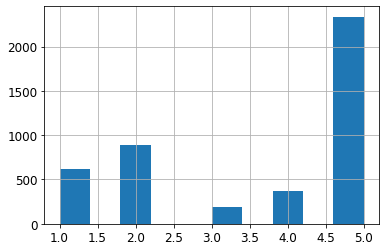

In [9]:
allData["DistanceFromHome_cat"].hist()

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(allData, allData["DistanceFromHome_cat"]):
    print(train_index, test_index) # 1 seul tour de boucle si n_splits = 1
    strat_train_set = allData.loc[train_index]
    strat_test_set = allData.loc[test_index]

[ 671 4064 1417 ... 1921 2460 2456] [1098  991 4077 4025 1284  679 4369  794  769 2189 4300 2667  408  732
 3962 1740 3521 3954 4138 3984  328 2377  663  570  505 1607 3375 1671
  324  735 3672 2102   79  688 1406  920  870  955 4244 2539 2835  391
  490 3584 2482 4007  718 2175 3701  178 3072 4382 2746  993  861 3023
 2158 1450 2727 2759  101 1363  576 1053 1540 2822 3529  480 3368 4288
  231 3928 3137  237  350  353 1116 2465 4107 1509 4381  821 1197 3711
  937  485 3669 2663  641 3645 2411 2675  801 3620 1488  286 4061  912
 2552  964 1751 1042 3800 1257   12  765  702 2931 3483 2624 4326  813
 2817  881 2545 2722 2376 1541 1131 2952 3496 3582 1472  188  299 3502
 1270 3307  752 3206 1247 4270 2954  658 3157 3107 4312 1316 3944  910
 2926 2661 3634 2360 2247 3533 4264 3309 2356 2702 3843 1712 3508 1126
 4019  731 1032 3836  579  251 1253  260 2011 3181 3493 4336 3895 3096
 2235 4220 4150 4199 1339 1463 2491 3648  246 2767   78 3897 1555 2861
 3686  889 1255 2227 2312 3377 2523 2705 

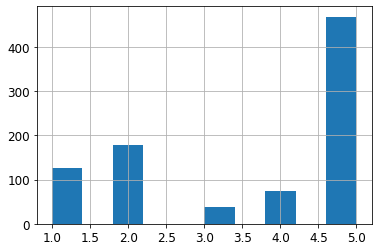

In [11]:
strat_test_set["DistanceFromHome_cat"].hist()

In [12]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("DistanceFromHome_cat", axis=1, inplace=True)

#### Corrélation

Les variables d'un jeu de données peuvent être liées deux à deux (plus ou moins fortement, positivement ou négativement), c'est pourquoi on calcule leur `corrélation`

In [13]:
dataCorr = strat_train_set.copy()
dataCorr.corr()['DistanceFromHome']

EmployeeID                -0.004834
EnvironmentSatisfaction    0.036137
JobSatisfaction           -0.005699
WorkLifeBalance           -0.001166
Age                        0.009935
DistanceFromHome           1.000000
Education                 -0.008776
EmployeeCount                   NaN
JobLevel                  -0.041281
MonthlyIncome             -0.025152
NumCompaniesWorked        -0.003218
PercentSalaryHike          0.023426
StandardHours                   NaN
StockOptionLevel           0.025746
TotalWorkingYears          0.010984
TrainingTimesLastYear     -0.011505
YearsAtCompany             0.028654
YearsSinceLastPromotion   -0.009053
YearsWithCurrManager       0.019712
JobInvolvement             0.005755
PerformanceRating          0.023838
Name: DistanceFromHome, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D423FE7888>]],
      dtype=object)

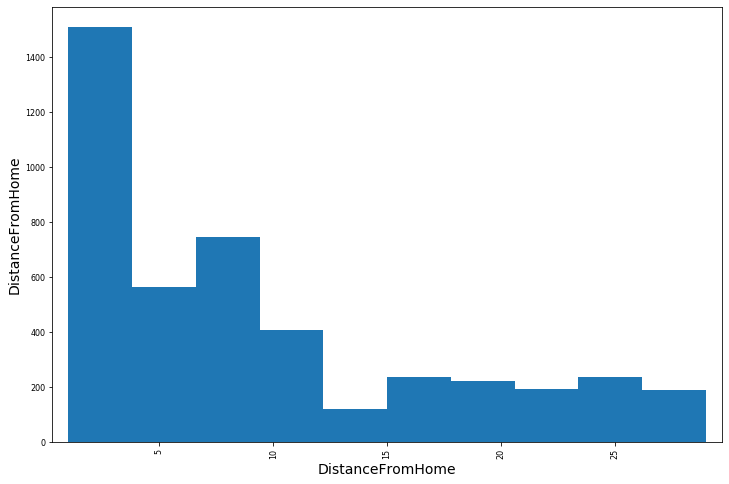

In [15]:
from pandas.plotting import scatter_matrix

attributes = ["DistanceFromHome"]
scatter_matrix(allData[attributes], figsize=(12, 8))

### Pipeline ML

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

num_attribs = list(X)
cat_attribs = ["BusinessTravel", "Attrition", "EducationField", "Department", "Gender", "JobRole", "MaritalStatus", "Over18"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('std_scaler', StandardScaler()),
    ])

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

dataSetPipeline = full_pipeline.fit_transform(allData)
dataSetPipeline

array([[-1.7316581 ,  1.54136892, -0.39393818, ...,  1.        ,
         0.        ,  1.        ],
       [-1.73087259, -0.64866811,  0.09963874, ...,  0.        ,
         1.        ,  1.        ],
       [-1.73008708, -0.53916626,  0.96339837, ...,  1.        ,
         0.        ,  1.        ],
       ...,
       [ 1.73008708, -1.30567922,  1.95055222, ...,  1.        ,
         0.        ,  1.        ],
       [ 1.73087259,  0.55585225,  1.0867926 , ...,  0.        ,
         0.        ,  1.        ],
       [ 1.7316581 ,  0.33684855,  2.32073492, ...,  0.        ,
         0.        ,  1.        ]])

In [19]:
dataSetPipeline.shape

(4410, 45)